# Prepare the Data
First, import the libraries you will need and prepare the training and test data:

In [10]:

from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator



# Data description
Budget: the budget of the movie,
domesticgross: the revenue of movie in the United States,
globalgross: the revenue of movie globally,
duration: the length of the movie,
language: the language of the movie,
country: country that release the movie,
imdb_score: the rating of movie,
majorgenres: the major type of the movie

In [11]:
sqlContext = SQLContext(sc)
movieschema = StructType([\
        StructField('Budget', DoubleType(), False),\
        StructField('domesticgross', DoubleType(), False),\
        StructField('globalgross', DoubleType(), False),\
        StructField('duration', DoubleType(), False),\
        StructField('language', IntegerType(), False),\
        StructField('country', IntegerType(), False),\
        StructField('imdb_score', DoubleType(), False),\
        StructField('majorgenres', IntegerType(), False),\
    ])
movieschema

StructType(List(StructField(Budget,DoubleType,false),StructField(domesticgross,DoubleType,false),StructField(globalgross,DoubleType,false),StructField(duration,DoubleType,false),StructField(language,IntegerType,false),StructField(country,IntegerType,false),StructField(imdb_score,DoubleType,false),StructField(majorgenres,IntegerType,false)))

# Insert SparkSession DataFrame from the file
click the insert to code button on the csv file then click on the insert SparkSession DataFrame

In [12]:

from pyspark.sql import SparkSession

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_ce6b74a554044ac18da2684a94f2bf47(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '571b641469df40cdb9cdf21a9ec8bdf6')
    hconf.set(prefix + '.username', 'bd693708437147129b446bf93514b247')
    hconf.set(prefix + '.password', 'k9a5-oNA.w#LaAW(')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_ce6b74a554044ac18da2684a94f2bf47(name)

spark = SparkSession.builder.getOrCreate()

df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('swift://sparkProject.' + name + '/movieprojectazure.csv')
df_data_1.take(5)


[Row(Budget=u'1', domesticgross=u'1', globalgross=u'2783918982', duration=u'0.339285714285714', language=u'1', country=u'1', imdb_score=u'0.79746835443038', majorgenres=u'2'),
 Row(Budget=u'0.705877508570729', domesticgross=u'0.263079399203666', globalgross=u'879620923', duration=u'0.279761904761905', language=u'1', country=u'2', imdb_score=u'0.658227848101266', majorgenres=u'2'),
 Row(Budget=u'0.647053010284875', domesticgross=u'0.589262914535552', globalgross=u'1084439099', duration=u'0.311507936507937', language=u'1', country=u'1', imdb_score=u'0.873417721518987', majorgenres=u'2'),
 Row(Budget=u'0.647053010284875', domesticgross=u'0.117423901647895', globalgross=u'260002115', duration=u'0.283730158730159', language=u'1', country=u'1', imdb_score=u'0.620253164556962', majorgenres=u'2'),
 Row(Budget=u'0.647053010284875', domesticgross=u'0.0960652146956492', globalgross=u'282778100', duration=u'0.248015873015873', language=u'1', country=u'1', imdb_score=u'0.632911392405063', majorgenr

In [13]:
csv = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .schema(movieschema)\
  .load('swift://sparkProject.' + name + '/movieprojectazure.csv')
csv.show(5)

+-----------------+------------------+-------------+-----------------+--------+-------+-----------------+-----------+
|           Budget|     domesticgross|  globalgross|         duration|language|country|       imdb_score|majorgenres|
+-----------------+------------------+-------------+-----------------+--------+-------+-----------------+-----------+
|              1.0|               1.0|2.783918982E9|0.339285714285714|       1|      1| 0.79746835443038|          2|
|0.705877508570729| 0.263079399203666| 8.79620923E8|0.279761904761905|       1|      2|0.658227848101266|          2|
|0.647053010284875| 0.589262914535552|1.084439099E9|0.311507936507937|       1|      1|0.873417721518987|          2|
|0.647053010284875| 0.117423901647895| 2.60002115E8|0.283730158730159|       1|      1|0.620253164556962|          2|
|0.647053010284875|0.0960652146956492|   2.827781E8|0.248015873015873|       1|      1|0.632911392405063|          2|
+-----------------+------------------+-------------+----

# Split data
select columns and Split data to 70% of training and 30% of testing

In [14]:
# Select features and label
data = csv.select("Budget", "domesticgross", "duration",'language','country',"imdb_score",'majorgenres', col("globalgross").alias("label"))

# Split the data
splits = data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1].withColumnRenamed("label", "trueLabel")

# Define the Pipeline
Now define a pipeline that creates a feature vector and trains a regression model

In [15]:
# Define the pipeline
assembler = VectorAssembler(inputCols = ["Budget", "domesticgross", "duration",'language','country',"imdb_score",'majorgenres'], outputCol="features")
lr = LinearRegression(labelCol="label",featuresCol="features")

pipeline = Pipeline(stages=[assembler, lr])


# Tune Parameters
You can tune parameters to find the best model for your data. To do this you can use the  **CrossValidator** class to evaluate each combination of parameters defined in a **ParameterGrid** against multiple *folds* of the data split into training and validation datasets, in order to find the best performing parameters. Note that this can take a long time to run because every parameter combination is tried multiple times.

In [16]:

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.01]).addGrid(lr.maxIter, [10, 5]).build()
# TODO: K = 2, you may test it with 5, 10
# K=2, 5, 10: Root Mean Square Error (RMSE): 13.2
cv = CrossValidator(estimator=pipeline, evaluator=RegressionEvaluator(), estimatorParamMaps=paramGrid, numFolds=10)

model = cv.fit(train)

# Test the Model
Now you're ready to apply the model to the test data.

In [17]:
prediction = model.transform(test)
predicted = prediction.select("features", "prediction", "trueLabel")
predicted.show()

+--------------------+--------------------+-----------+
|            features|          prediction|  trueLabel|
+--------------------+--------------------+-----------+
|[7.05893979430249...|-2.359775038118547E7|      527.0|
|[1.88238394514733...| -1.08063459724029E7|   115592.0|
|[3.76476789029466...|-2.279897926315905E7|  1227508.0|
|[4.2353638765815E...|-1.694766994468426E7|  2883661.0|
|[5.41185384229858...|-2.65215965110816...|    82698.0|
|[5.41185384229858...|  -2.6589207818315E7|   103509.0|
|[8.23542976001958...|-2.047244450272656E7|   342722.0|
|[2.18827133623377...|-1.634700346789869E7|    20056.0|
|[2.98828451292139...|-1.17440890852902...|  8000000.0|
|[3.60005929509427...| -1.91550488089697E7|    32092.0|
|[4.07065528138111...|-1.02671506882275...|    17503.0|
|[4.54125126766794...|-1.93421184220114...|     1217.0|
|[4.54125126766794...|-2.730028563667472E7|   346106.0|
|[4.54125126766794...|-2.76437745076366...|   140016.0|
|[4.54125126766794...|-1.55588776652208...|   43

# Examine the Predicted and Actual Values
You can plot the predicted values against the actual values to see how accurately the model has predicted. In a perfect model, the resulting scatter plot should form a perfect diagonal line with each predicted value being identical to the actual value - in practice, some variance is to be expected.
Run the cells below to create a temporary table from the **predicted** DataFrame and then retrieve the predicted and actual label values using SQL. You can then display the results as a scatter plot, specifying **-** as the function to show the unaggregated values.

In [18]:
predicted.createOrReplaceTempView("regressionPredictions")


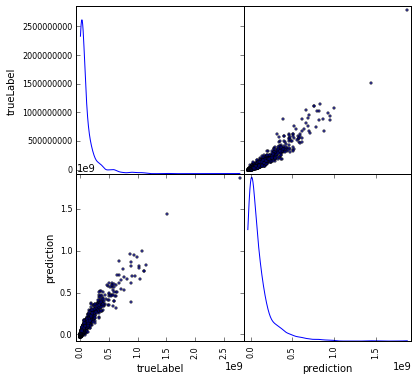

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

# Reference: http://standarderror.github.io/notes/Plotting-with-PySpark/
dataPred = spark.sql("SELECT trueLabel, prediction FROM regressionPredictions")
# convert to pandas and plot
regressionPredictionsPanda = dataPred.toPandas()
stuff = scatter_matrix(regressionPredictionsPanda, alpha=0.7, figsize=(6, 6), diagonal='kde')

# Retrieve the Root Mean Square Error (RMSE)
There are a number of metrics used to measure the variance between predicted and actual values. Of these, the root mean square error (RMSE) is a commonly used value that is measured in the same units as the prediced and actual values - so in this case, the RMSE indicates the average number of minutes between predicted and actual flight delay values. You can use the **RegressionEvaluator** class to retrieve the RMSE.


In [20]:
evaluator = RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print "Root Mean Square Error (RMSE):", rmse

Root Mean Square Error (RMSE): 57188471.1788
